In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv("0723_all_concat.csv", index_col = 0 )
data.head()

,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,1,3,11,395.433780,byplayer,0,3,10,1,2,...,0,2403.4287,0,0.0,0,1492.000,0,2498.04880,8,4
1,0,1,0,0.000000,byzone,0,0,55,0,0,...,0,0.0000,0,0.0,0,893.000,0,239.93445,2,15
2,10,3,7,1284.158400,alive,3,3,2,4,8,...,0,4998.7627,0,0.0,0,1613.508,0,1773.35990,3,1
3,0,0,1,88.794075,byplayer,0,0,13,1,1,...,0,4143.0120,1,0.0,0,1295.000,0,826.75073,4,2
4,8,3,9,916.480100,byplayer,3,1,1,2,6,...,2,5006.8066,0,0.0,0,1456.000,0,1779.63440,3,5


In [3]:
# 필요없는 변수 삭제
train = data.drop(columns = ["playerId","name"], axis = 1)

In [4]:
# 게임에서 튕긴 매치 제거
# 이동거리0 피해량0인 튕긴것같은 매치스텟

logout_index = train[(train["walkDistance"] == 0) & (train["damageDealt"] == 0)].index
train.drop(logout_index, inplace = True)

### Feature Engineering

In [ ]:
1. 이동거리 가중평균

In [6]:
# 가중치 결과값 → 수영 0.00 / 걷기 0.78 / 자동차 0.22
train["movement_w_mean"] = 0*train["swimDistance"] + 0.78*train["walkDistance"] + 0.22*train["vehicleDestroys"]

In [ ]:
2. 킬플레이스 / 윈플레이스

In [7]:
train["kill_over_winPlae"] = round(train["killPlace"]/train["winPlace"], 4)

In [ ]:
3. 킬수 / 생존시간

In [8]:
train["kill_over_timeSurvived"] = round(train["kills"]/train["timeSurvived"], 4)

In [ ]:
4. 라벨 인코딩

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
columns = ["deathType", "mapName", "matchType"]

for col in columns :
    label_encoder = LabelEncoder()
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36593 entries, 0 to 37064
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DBNOs                   36593 non-null  int64  
 1   assists                 36593 non-null  int64  
 2   boosts                  36593 non-null  int64  
 3   damageDealt             36593 non-null  float64
 4   deathType               36593 non-null  int32  
 5   headshotKills           36593 non-null  int64  
 6   heals                   36593 non-null  int64  
 7   killPlace               36593 non-null  int64  
 8   killStreaks             36593 non-null  int64  
 9   kills                   36593 non-null  int64  
 10  longestKill             36593 non-null  float64
 11  mapName                 36593 non-null  int32  
 12  matchType               36593 non-null  int32  
 13  revives                 36593 non-null  int64  
 14  rideDistance            36593 non-null

## Normalization

### MinMaxScaler

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

train_scaled_df = pd.DataFrame(data = train_scaled, columns = train.columns )

train_scaled_df.shape

(36593, 26)

### StandardScaler

In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

sta_train_scaled_df = pd.DataFrame(data = train_scaled, columns = train.columns )

train_scaled_df.shape

(36593, 28)

## PCA 차원축소

In [24]:
from sklearn.decomposition import PCA

n_columns = 13
pca = PCA(n_components = 13)
pca.fit(train)

PCA(n_components=13)

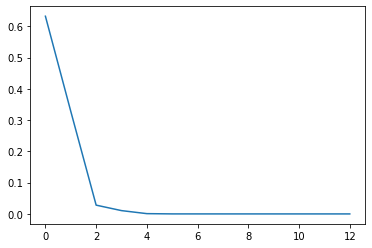

In [26]:
plt.plot(pca.explained_variance_ratio_)

In [99]:
n_columns = 3
pca = PCA(n_components = 3)
pca.fit(train)

np.sum(pca.explained_variance_ratio_)

0.9884635577554896

In [101]:
train_pca = pca.transform(train)

##########################  여기 주의하기 #######################
mMs = MinMaxScaler()
stand = StandardScaler()
train_pca_norm = mMs.fit_transform(train_pca)
train_pca_df = pd.DataFrame(data = train_pca_norm, columns = ['pc1', 'pc2', 'pc3'])

## DBSCAN

In [127]:
from sklearn.cluster import DBSCAN

# SETTING
dbs = DBSCAN(eps= .6, min_samples = 8, metric = "euclidean")

# OUTPUT
dbs_labels = dbs.fit_predict(train_pca) # DBSCAN 클러스터 라벨링 객체 생성

# STACKING
train_scaled_df['DBSCAN_cluster'] = dbs_labels

In [84]:
train_scaled_df

,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,kills,...,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,movement_w_mean,kill_over_winPlae,kill_over_timeSurvived,DBSCAN_cluster,silhouette_coeff
0,0.019231,0.230769,0.500000,0.050919,0.25,0.000000,0.083333,0.069231,0.0625,0.030769,...,0.752643,0.00,0.029433,0.037736,0.030303,0.029433,0.030839,0.001598,-1,0.118074
1,0.000000,0.076923,0.000000,0.000000,0.50,0.000000,0.000000,0.415385,0.0000,0.000000,...,0.450070,0.00,0.002827,0.009434,0.141414,0.002827,0.045429,0.000000,-1,-0.080722
2,0.192308,0.230769,0.318182,0.165359,0.00,0.107143,0.083333,0.007692,0.2500,0.123077,...,0.814020,0.00,0.020894,0.014151,0.000000,0.020894,0.024587,0.006146,-1,0.149450
3,0.000000,0.000000,0.045455,0.011434,0.25,0.000000,0.000000,0.092308,0.0625,0.015385,...,0.653133,0.00,0.009741,0.018868,0.010101,0.009741,0.080861,0.000983,-1,-0.082993
4,0.153846,0.230769,0.409091,0.118013,0.25,0.107143,0.027778,0.000000,0.1250,0.092308,...,0.734458,0.00,0.020968,0.014151,0.040404,0.020968,0.002077,0.005040,-1,0.194579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36588,0.019231,0.000000,0.409091,0.051482,0.00,0.035714,0.111111,0.115385,0.0625,0.015385,...,0.936111,0.00,0.019863,0.033019,0.000000,0.019863,0.199661,0.000615,-1,0.021840
36589,0.038462,0.076923,0.136364,0.058318,0.25,0.071429,0.055556,0.023077,0.1250,0.046154,...,0.588476,0.00,0.018736,0.028302,0.000000,0.018736,0.049597,0.003196,-1,0.063330
36590,0.038462,0.076923,0.363636,0.100897,0.00,0.000000,0.333333,0.215385,0.0000,0.000000,...,0.897774,0.25,0.014120,0.037736,0.000000,0.014124,0.362230,0.000000,-1,0.026117
36591,0.096154,0.076923,0.545455,0.140288,0.00,0.142857,0.138889,0.000000,0.1250,0.123077,...,0.924690,0.50,0.024720,0.018868,0.000000,0.024727,0.012081,0.005409,-1,0.112824


### ESTIMATING

In [91]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [128]:
# 모든 개별 데이터 실루엣 계수 값 구하기
score_samples = silhouette_samples(train_scaled, train_scaled_df["DBSCAN_cluster"])
print("silhouette_samples() return 값의 shape", score_samples.shape)

silhouette_samples() return 값의 shape (36593,)


In [129]:
# train_scaled_df에 실루엣 계수 컬럼 추가
train_scaled_df["silhouette_coeff"] = score_samples

In [130]:
# 모든 데이터의 평균 실루엣 계수 값 구하기
average_score = silhouette_score(train_scaled, train_scaled_df["DBSCAN_cluster"])
print("개인 플레이 성향 Silhouette Analysis Score: {0:3f}".format(average_score))

개인 플레이 성향 Silhouette Analysis Score: 0.012110
